In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import eternabench as eb
from RiboGraphViz import RGV
from scipy.stats import spearmanr, pearsonr
import sys, os
#draw_rna
from ipynb.draw import draw_struct

import logomaker

Populating the interactive namespace from numpy and matplotlib


In this notebook:

- [x] Figure 1B -- Cloud lab project metadata

- [x] Figure 1D -- Cloud lab dataset statistics

- [x] Figure S3 -- Cloud lab filtering descriptive stats

- [ ] Figure S6 -- Correlations of Dataset statistics and mean package correlation

- [x] Figure S14 -- EternaFold train/holdout descriptive stats



In [2]:
#df = eb.load_CM_unfiltered_data()
df = pd.read_json('../data/EternaBench_ChemMapping_Full_10Jul2021.json.zip')
punp_var_Df = pd.read_json('../data/EternaBench_ChemMapping_PUnpaired_Stdev.json.zip')

df['Std. in p(unp) calculations'] = punp_var_Df['punp_stdev']

In [6]:
df['GC content'] = [(x.count('G')+x.count('C'))/len(x) for x in df['sequence']]
df['Length'] = [len(x)-21 for x in df['sequence']]
df['signal_to_noise'] = [float(x.split(':')[-1]) for x in df['signal_to_noise']]
df['Max. reactivity'] = df.apply(lambda row: np.max(row['reactivity']), axis=1)
df['Median reactivity'] = df.apply(lambda row: np.median(row['reactivity']), axis=1)

def get_RGV_stats(row):
    try:
        mdl = RGV(row['structure'])
        mdl.run_structure_properties()
        loop_count = len(list([x for x in mdl.G.nodes if isinstance(x, int)]))-1
        return loop_count, np.clip(mdl.n_hairpins,0,100), mdl.n_internal_loops, mdl.n_3WJs + mdl.n_4WJs+ mdl.n_5WJs_up
    except:
        struct = row['structure'].replace('))(((((((....))))))).....................','..(((((((....))))))).....................')
        mdl = RGV(struct)
        mdl.run_structure_properties()
        loop_count = len(list([x for x in mdl.G.nodes if isinstance(x, int)]))-1
        return loop_count, np.clip(mdl.n_hairpins,0,100), mdl.n_internal_loops, mdl.n_3WJs + mdl.n_4WJs + mdl.n_5WJs_up
    
unique_struct_df = pd.DataFrame({'structure': [x for x in set(df.structure)]}) 
unique_struct_df[['Target structure, total loops', 'Target structure, # hairpins','Target structure, # Internal loops','Target structure, # Multiloops']] =\
unique_struct_df.apply(lambda row: get_RGV_stats(row), axis=1, result_type='expand')
df = df.merge(unique_struct_df, on='structure')

In [8]:
df_filt.groupby(['split']).size()

split
Holdout      709
Test       12367
Train       1263
dtype: int64

In [5]:
df.to_json('CloudLabMetadata.json.zip')

In [10]:
# data on datasets for paper

print(df.loc[df.passed_CDHIT_filter].groupby('Dataset').size().median())

577.0


In [52]:
project_scores = pd.read_csv(os.environ['ETERNABENCH_PATH']+'/scoring_data/EB_projects_-efold_pearson_zscores_by_project_name.csv')
print(len(project_scores))
project_scores = project_scores.loc[project_scores.pearson_std<0.05]
print(len(project_scores))

project_variance = project_scores.groupby(['project_name'])['pearson_mean'].std()
project_variance = project_variance.reset_index()
project_variance['Stddev_of_package_correlations'] = project_variance['pearson_mean']
project_variance = project_variance.drop(columns=['pearson_mean'])


project_mean = project_scores.groupby(['project_name'])['pearson_mean'].mean()
project_mean = project_mean.reset_index()
project_mean['Mean_of_package_correlations'] = project_mean['pearson_mean']
project_mean = project_mean.drop(columns=['pearson_mean'])


21864
13583


In [62]:
cfold_zscores = project_scores.loc[project_scores.package=='contrafold_2']
cfold_zscores['cfold_zscore'] = cfold_zscores['pearson_zscore_by_project_name_mean']
cfold_zscores = cfold_zscores[['project_name', 'cfold_zscore']]
proj_stats_filt = proj_stats_filt.merge(cfold_zscores, on='project_name')

In [59]:
project_scores = project_scores.loc[project_scores.pearson_std<0.05]
tmp, package_list, dataset_list = eb.plot.create_array(project_scores, 'package', 'project_name', 'pearson_zscore_by_project_name_mean')

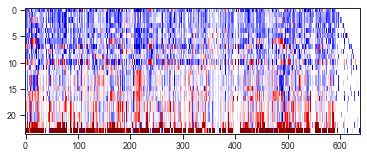

In [59]:
imshow(tmp,cmap='seismic_r', vmin=-2, vmax=2,aspect=10)

In [14]:
def create_project_stats(df):
    project_stats = df.groupby(['Dataset','project_name']).mean()
    project_sizes = df.groupby(['Dataset','project_name'])['sequence'].size()

    project_sizes = project_sizes.reset_index()
    project_stats = project_stats.reset_index()
    project_stats['# constructs'] = project_sizes['sequence']
    project_stats = project_stats.loc[~project_stats.Dataset.isna()]
    project_stats = project_stats.loc[project_stats.Dataset!='RYOS_I']
    
    proj_entropies = pd.DataFrame()
    for proj_name in df.project_name.unique():
        if proj_name is not None:
            seqs = [x for x in df.loc[df.project_name==proj_name]['sequence']]
            n_lengths = len(list(set([len(x) for x in seqs])))
            if n_lengths == 1:
                entropy = eb.sequence_analysis.positional_entropy(seqs)
                proj_entropies = proj_entropies.append({'project_name': proj_name, 'Sequence Entropy': entropy/np.log(4)}, ignore_index=True)

    project_stats = project_stats.merge(proj_entropies, on='project_name',how='left')
    return project_stats

proj_stats = create_project_stats(df)
proj_stats_filt = create_project_stats(df.loc[df.passed_CDHIT_filter==True])
proj_stats_filt = proj_stats_filt.merge(project_mean,on='project_name',how='left')
proj_stats_filt = proj_stats_filt.merge(project_variance,on='project_name',how='left')

In [23]:
proj_stats_filt.to_json('proj_stats_filt.json.zip')

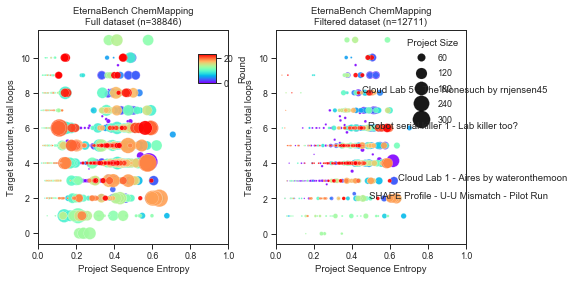

In [97]:

fig, ax = plt.subplots(1,2,figsize=(8,4))

im = ax[0].scatter(proj_stats['Sequence Entropy'], proj_stats['Target structure, total loops'], s=proj_stats['# constructs'],
        c=[int(x.split(' ')[-1]) for x in proj_stats['Dataset']], cmap='rainbow',alpha=0.9,linewidth=0.2,edgecolor='w')
plt.legend(*im.legend_elements("sizes", num=6),title='Project Size',frameon=False)

ax[0].set_title('EternaBench ChemMapping\nFull dataset (n=38846)')
ax[0].set_ylabel('Target structure, total loops')
ax[0].set_xlabel('Project Sequence Entropy')
ax[0].set_xlim([0,1])

cbaxes = fig.add_axes([0.35,0.7, 0.03, 0.1]) 
fig.colorbar(im, cax = cbaxes, label='Round')

ax[1].scatter(proj_stats_filt['Sequence Entropy'], proj_stats_filt['Target structure, total loops'],
        s=proj_stats_filt['# constructs'], c=[int(x.split(' ')[-1]) for x in proj_stats_filt['Dataset']],
        cmap='rainbow',alpha=0.9,linewidth=0.2,edgecolor='w')


exs=['Robot serial killer 1 - Lab killer too?',
'Cloud Lab 5 - The Nonesuch by rnjensen45',
'SHAPE Profile - U-U Mismatch - Pilot Run',
    'Cloud Lab 1 - Aires by wateronthemoon']

for p in exs:
    ax[1].text(proj_stats_filt.loc[proj_stats_filt.project_name==p]['Sequence Entropy'].iloc[0]+0.02,
            proj_stats_filt.loc[proj_stats_filt.project_name==p]['Target structure, total loops'].iloc[0],
         p,zorder=10)

ax[1].set_title('EternaBench ChemMapping\nFiltered dataset (n=12711)')
ax[1].set_ylabel('Target structure, total loops')
ax[1].set_xlabel('Project Sequence Entropy')
ax[1].set_xlim([0,1])

tight_layout()
savefig('FIGURES/1/CloudLab_both_bubble_plots.pdf',bbox_inches='tight')

In [96]:
rand_projs = proj_stats_filt.sample(n=3)['project_name'].values
print(rand_projs)

['SHAPE Profile - G/A Hairpin Terminal Mismatch and Neighboring Base Pairs GNCgaaaaGNC - Shape 0'
 'Cloud Lab 5 - The Nonesuch by rnjensen45'
 'The RFAM Mapping project - Shape 10']


In [19]:
proj_stats_filt.keys()

Index(['Dataset', 'project_name', 'passed_CDHIT_filter', 'signal_to_noise',
       'EternaScore', 'Std. in p(unp) calculations', 'GC content', 'Length',
       'Target structure, total loops', 'Target structure, # hairpins',
       'Target structure, # Internal loops', 'Target structure, # Multiloops',
       '# constructs', 'Sequence Entropy', 'Mean_of_package_correlations',
       'Stddev_of_package_correlations'],
      dtype='object')

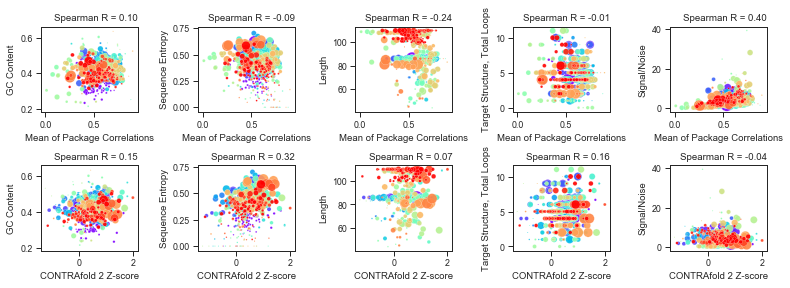

In [166]:
xmetrics = ['Mean_of_package_correlations','cfold_zscore']
#,'Std. in p(unp) calculations'
#'EternaScore',

ymetrics = ['GC content', 'Sequence Entropy','Length','Target structure, total loops','signal_to_noise']

xlabels = ['Mean of Package Correlations', 'CONTRAfold 2 Z-score']
figure(figsize=(11,4))
for i, x in enumerate(xmetrics):
    for j, y in enumerate(ymetrics):
        subplot(len(xmetrics),len(ymetrics),i*len(ymetrics)+j+1)
        scatter(proj_stats_filt[x], proj_stats_filt[y],
        s=proj_stats_filt['# constructs'], c=[int(x.split(' ')[-1]) for x in proj_stats_filt['Dataset']],
        cmap='rainbow',alpha=0.9,linewidth=0.2,edgecolor='w')
        xlabel(xlabels[i])
        ylabel(y.replace('_to_n','/N').title().replace('Gc','GC'))
        
        eb.plot.corrfunc(proj_stats_filt[x], proj_stats_filt[y])
tight_layout()
savefig('FIGURES/SI/FigureS6_compare_mean_package_corrs.pdf',bbox_inches='tight')
savefig('FIGURES/SI/FigureS6_compare_mean_package_corrs.png',dpi=300, bbox_inches='tight')

In [167]:
proj_stats_filt.to_csv('TABLES/proj_details.csv',index=False)

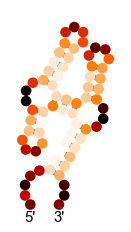

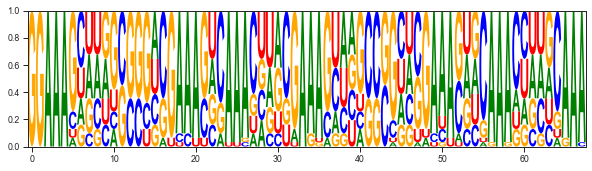

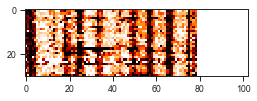

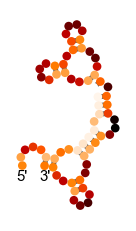

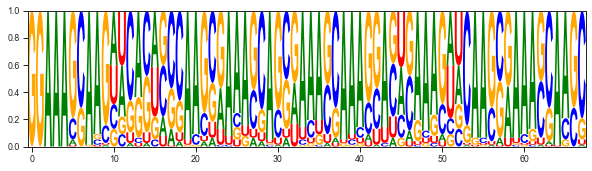

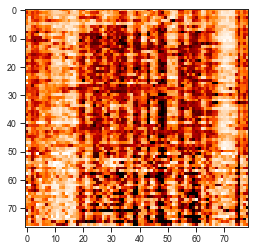

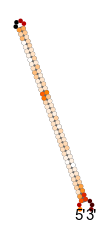

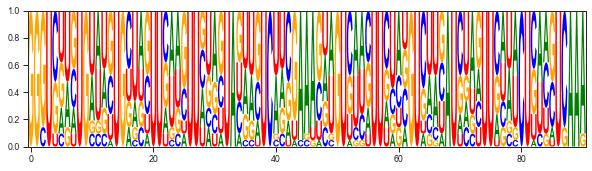

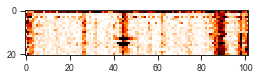

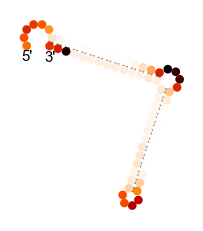

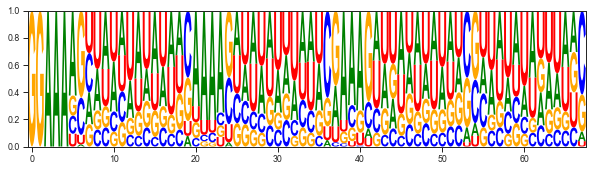

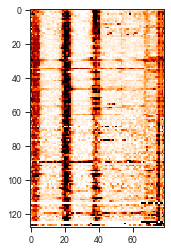

In [103]:
# Visualize subset of projects

project_list = ['New Frontier 3', 'Shape Library 101: The Finger','Cloud Lab 1 - Aires by wateronthemoon', 'Permuted loops', 'Don Quixote']

for proj in exs:
    tmp = df.loc[df.passed_CDHIT_filter==True].loc[df.project_name==proj]
    cat_reac_data = np.vstack([x for x in tmp['reactivity']])
    struct = tmp.iloc[0]['structure'][:-39]
    reac_mean = np.mean(cat_reac_data, axis=0)[:len(struct)]
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    draw_struct(' '*len(struct), struct, c = reac_mean, cmap='gist_heat_r',ax=ax)
    savefig('FIGURES/1/'+proj+'reac_on_struct.pdf',bbox_inches='tight')
    seqs = [x[:-39] for x in tmp.sequence]
    seqlogo = eb.sequence_analysis.make_logomaker_df(seqs)
    logomaker.Logo(seqlogo)
    figure(figsize=(4,4))
    imshow(cat_reac_data, cmap='gist_heat_r',vmin=0,vmax=1.5)
    savefig('FIGURES/1/'+proj+'reac_heatmap.pdf',bbox_inches='tight')

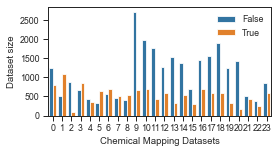

In [153]:
figure(figsize=(4,2))
tmp = df.groupby(['Dataset','passed_CDHIT_filter']).size()
tmp = tmp.reset_index()
tmp = tmp.loc[tmp.Dataset!='RYOS_I']
sns.barplot(x='Dataset', y=0, data=tmp,hue='passed_CDHIT_filter')
xticks(range(24), range(24))
ylabel('Dataset size')
xlabel('Chemical Mapping Datasets')
legend(frameon=False)
savefig('FIGURES/SI/Figure_S3A.pdf',bbox_inches='tight')


<Figure size 864x432 with 0 Axes>

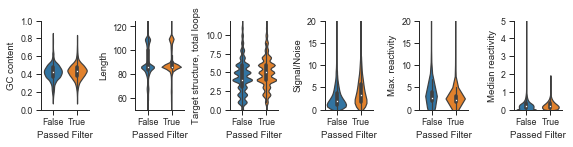

In [154]:
figure(figsize=(12,6))

# proj_stats['EternaBench']='Full (n=38846)'
# proj_stats_filt['EternaBench']='Filtered (n=12711)'
# tmp = pd.concat([proj_stats, proj_stats_filt])

figure(figsize=(8,2))
ymin=[0,50,0,0,0,0]
ymaxes=[1,125,12,20,20,5]
for i, metric in enumerate(['GC content','Length','Target structure, total loops', 'signal_to_noise', 'Max. reactivity','Median reactivity']):
    subplot(1,6,i+1)
    sns.violinplot(x='passed_CDHIT_filter', y=metric, data=df, fliersize=0)
    ylim([ymin[i],ymaxes[i]])
    
    if metric=='signal_to_noise':
        ylabel('Signal/Noise')
        
    xlabel('Passed Filter')
    ax=gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

tight_layout()

savefig('FIGURES/SI/Figure_S3B.pdf',bbox_inches='tight')

In [45]:
stats = df.groupby('Dataset')[['GC content','Length','Target structure, total loops','signal_to_noise']].agg([np.median, np.std, np.size])
filt_stats = df.loc[df.passed_CDHIT_filter==True].groupby('Dataset')[['GC content','Length','Target structure, total loops','signal_to_noise']].agg([np.median, np.std, np.size])
stats.to_csv('TABLES/ChemMapping_FULL_metadata_by_dataset.csv', index=False)
filt_stats.to_csv('TABLES/ChemMapping_Filtered_metadata_by_dataset.csv', index=False)

proj_stats.to_csv('TABLES/ChemMapping_FULL_metadata_by_project.csv', index=False)
proj_stats_filt.to_csv('TABLES/ChemMapping_Filtered_metadata_by_project.csv', index=False)


In [10]:
# Incorporate EternaFold train/test/holdout information

test_set_seqs=[]
train_set_seqs=[]
holdout_set_seqs=[]
with open('test_seqs.txt','r') as f:
    for lin in f.readlines():
        seq = lin.strip()
        test_set_seqs.append(seq)
        
with open('train_seqs.txt','r') as f:
    for lin in f.readlines():
        seq = lin.strip()
        train_set_seqs.append(seq)
        
with open('holdout_seqs.txt','r') as f:
    for lin in f.readlines():
        seq = lin.strip()
        holdout_set_seqs.append(seq)
        
def find_mapping(row):
    for seq in train_set_seqs:
        if row['sequence'].startswith(seq):
            return 'Train'
    for seq in holdout_set_seqs:
        if row['sequence'].startswith(seq):
            return 'Holdout'
    else:
        return "Test"
    
df_filt = df.loc[df.passed_CDHIT_filter==True]
df_filt['split'] = df_filt.apply(lambda row: find_mapping(row), axis=1)


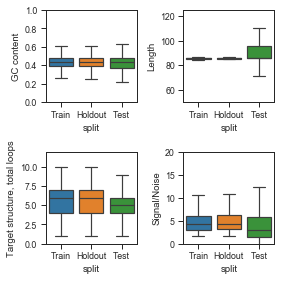

In [83]:
figure(figsize=(4,4))
ymin=[0,50,0,0]
ymaxes=[1,125,12,20]
for i, metric in enumerate(['GC content','Length','Target structure, total loops', 'signal_to_noise']):
    subplot(2,2,i+1)
    sns.boxplot(x='split', y=metric, data=df_filt, order=['Train','Holdout','Test'], fliersize=0)
    ylim([ymin[i],ymaxes[i]])
    if metric=='signal_to_noise':
        ylabel('Signal/Noise')
tight_layout()
savefig('FIGURES/SI/Figure_S14_Efold_splits_stats.pdf',bbox_inches='tight')
savefig('FIGURES/SI/Figure_S14_Efold_splits_stats.png',dpi=300, bbox_inches='tight')

<Figure size 864x432 with 0 Axes>

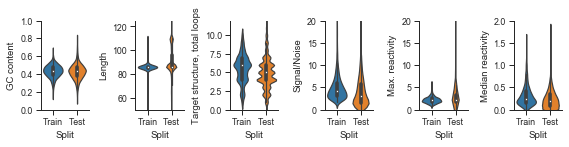

In [12]:
figure(figsize=(12,6))

# proj_stats['EternaBench']='Full (n=38846)'
# proj_stats_filt['EternaBench']='Filtered (n=12711)'
# tmp = pd.concat([proj_stats, proj_stats_filt])

figure(figsize=(8,2))
ymin=[0,50,0,0,0,0]
ymaxes=[1,125,12,20,20,2]
for i, metric in enumerate(['GC content','Length','Target structure, total loops', 'signal_to_noise', 'Max. reactivity','Median reactivity']):
    subplot(1,6,i+1)
    sns.violinplot(x='split', y=metric, data=df_filt, order=['Train','Test'], fliersize=0)
    ylim([ymin[i],ymaxes[i]])
    
    if metric=='signal_to_noise':
        ylabel('Signal/Noise')
        
    xlabel('Split')
    ax=gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

tight_layout()

savefig('FIGURES/SI/Figure_S14A.pdf',bbox_inches='tight')

In [13]:
df_filt[['GC content','Length','Target structure, total loops', 'signal_to_noise', 'split']].groupby('split').median()

,GC content,Length,"Target structure, total loops",signal_to_noise
split,,,,
Holdout,0.438462,86,6,4.224
Test,0.429907,86,5,2.973
Train,0.434783,86,6,4.193
